## Detection of correlated input to FS with and without gap junctions.

There are two population units for FS neurons, population unit 1 and population unit 2. In addition there are FS units without a population unit (0). The two population units receive cortical and thalamic input with 2Hz frequency. The correlation of population unit 1 is increased between 1 and 1.1 seconds for the cortical input, and between 2 and 2.1 seconds for the thalamic input.

In [1]:
import os
import numpy as np

os.environ["SNUDDA_DATA"] = "../../../../BasalGangliaData/data/"
assert os.path.isdir(os.getenv("SNUDDA_DATA")), f"You need to have BasalGangliaData installed for this example."

network_path = os.path.join("networks", "FS_correlation_detection")
rc = None

In [2]:
from snudda import SnuddaInit
si = SnuddaInit(network_path=network_path, random_seed=12345)
si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=1050, num_LTS=0, num_ChIN=0, neuron_density=1050)

# The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
# First test, we place units on top of each other -- set num_neurons to 8
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                               probability_function="(d < 400e-6)*1", num_neurons=150)
si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                               unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                               probability_function="(d < 400e-6) * 1", num_neurons=150)
 
si.write_json()

Using cube for striatum
Neurons for striatum read from /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum
Adding neurons: FS from dir /home/hjorth/HBP/BasalGangliaData/data/neurons/striatum/fs
Writing networks/FS_correlation_detection/network-config.json


In [3]:
# Smaller network -- TESTING
if False:
    from snudda import SnuddaInit
    si = SnuddaInit(network_path=network_path, random_seed=12345)
    si.define_striatum(num_dSPN=0, num_iSPN=0, num_FS=10, num_LTS=0, num_ChIN=0, neuron_density=1046)

    # The centre of the cube is [0.00475, 0.004, 0.00775]. num_neurons is optional
    # First test, we place units on top of each other -- set num_neurons to 8
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=1, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 100e-6, 0]),
                                   probability_function="(d < 300e-6)*1", num_neurons=4)
    si.add_population_unit_density(structure_name="Striatum", neuron_types=["FS"], unit_id=2, 
                                   unit_centre=np.array([0.00475, 0.004, 0.00775]) -np.array([0, 0, 100e-6]),
                                   probability_function="(d < 300e-6) * 1", num_neurons=4)

    si.write_json()

In [4]:
from snudda import SnuddaPlace
sp = SnuddaPlace(network_path=network_path)
sp.place()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA


### Plotting the network
Plotting the network to verify that the population units are placed the way we expect.

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Population unit 0 has 750 neurons
Population unit 1 has 150 neurons
Population unit 2 has 150 neurons


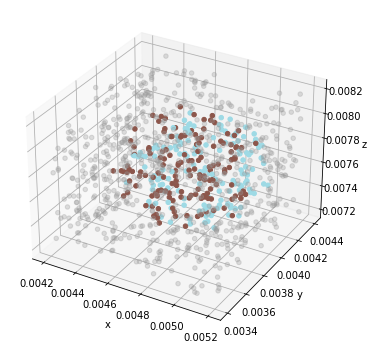

In [5]:
from snudda.plotting import PlotNetwork
pos_file = os.path.join(network_path, "network-neuron-positions.hdf5")

pn = PlotNetwork(pos_file)
pn.plot_populations()

# The commented code below also plots the network, but with the option to plot more detail of the neurons:
# pn = PlotNetwork(network_path)
# pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False, colour_population_unit=True)

pn.close()  # Close the hdf5 file so others can use it (or better shut down kernel after)

### Check if ipyparallel running
For larger networks it is useful to run network creation in parallel.

In [6]:
import os
from ipyparallel import Client

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

u_file = os.path.join(".ipython", "profile_default", "security", "ipcontroller-client.json")
if os.path.exists(u_file):
    rc = Client(url_file=u_file, timeout=120, debug=False)
else:
    print("Warning, running in serial.")
    rc = None

Warning, running in serial.


In [7]:
from snudda import SnuddaDetect

sd = SnuddaDetect(network_path=network_path, rc=rc, verbose=False)
sd.detect()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
No d_view specified, running distribute neurons in serial
Processing hyper voxel : 581/1452 (398 neurons)
Processing hyper voxel : 580/1452 (333 neurons)
Processing hyper voxel : 593/1452 (322 neurons)
Processing hyper voxel : 569/1452 (321 neurons)
Processing hyper voxel : 449/1452 (320 neurons)
Processing hyper voxel : 713/1452 (319 neurons)
Processing hyper voxel : 568/1452 (291 neurons)
Processing hyper voxel : 582/1452 (285 neurons)
Processing hyper voxel : 437/1452 (284 neurons)
Processing hyper voxel : 592/1452 (275 neurons)
Processing hyper voxel : 448/1452 (270 neurons)
Processing hyper voxel : 712/1452 (267 neurons)
Processing hyper voxel : 450/1452 (255 neurons)
Processing hyper voxel : 461/1452 (244 neurons)
Processing hyper voxel : 725/1452 (244 neurons)
Processing hyper voxel : 701/1452 (243 neuro

Processing hyper voxel : 171/1452 (15 neurons)
Processing hyper voxel : 452/1452 (15 neurons)
Processing hyper voxel : 547/1452 (15 neurons)
Processing hyper voxel : 186/1452 (15 neurons)
Processing hyper voxel : 842/1452 (14 neurons)
Processing hyper voxel : 560/1452 (14 neurons)
Processing hyper voxel : 464/1452 (14 neurons)
Processing hyper voxel : 677/1452 (14 neurons)
Processing hyper voxel : 602/1452 (14 neurons)
Processing hyper voxel : 830/1452 (14 neurons)
Processing hyper voxel : 174/1452 (14 neurons)
Processing hyper voxel : 314/1452 (14 neurons)
Processing hyper voxel : 209/1452 (14 neurons)
Processing hyper voxel : 823/1452 (13 neurons)
Processing hyper voxel : 704/1452 (13 neurons)
Processing hyper voxel : 1000/1452 (13 neurons)
Processing hyper voxel : 486/1452 (13 neurons)
Processing hyper voxel : 584/1452 (13 neurons)
Processing hyper voxel : 422/1452 (13 neurons)
Processing hyper voxel : 484/1452 (13 neurons)
Processing hyper voxel : 280/1452 (12 neurons)
Processing h

Processing hyper voxel : 998/1452 (1 neurons)
Processing hyper voxel : 1119/1452 (1 neurons)
Processing hyper voxel : 992/1452 (1 neurons)
Processing hyper voxel : 1003/1452 (1 neurons)
Processing hyper voxel : 853/1452 (1 neurons)
Processing hyper voxel : 849/1452 (1 neurons)
Processing hyper voxel : 1010/1452 (1 neurons)
Processing hyper voxel : 1011/1452 (1 neurons)
Processing hyper voxel : 1013/1452 (1 neurons)
Processing hyper voxel : 1073/1452 (1 neurons)
Processing hyper voxel : 973/1452 (1 neurons)
Processing hyper voxel : 1082/1452 (1 neurons)
Processing hyper voxel : 1083/1452 (1 neurons)
Processing hyper voxel : 878/1452 (1 neurons)
Processing hyper voxel : 879/1452 (1 neurons)
Processing hyper voxel : 1084/1452 (1 neurons)
Processing hyper voxel : 1095/1452 (1 neurons)
Processing hyper voxel : 883/1452 (1 neurons)
Processing hyper voxel : 1097/1452 (1 neurons)
Processing hyper voxel : 1106/1452 (1 neurons)
Processing hyper voxel : 1107/1452 (1 neurons)
Processing hyper voxe

In [8]:
from snudda import SnuddaPrune

sp = SnuddaPrune(network_path=network_path, rc=rc, verbose=False)
sp.prune()

Read 293608 out of total 293608 synapses
Read 25215 out of total 25215 gapJunctions


### Generate input

Next we generate the input according to specifications in [FS-input-correlation-detection-1.json](FS-input-correlation-detection-1.json)

In [9]:
from snudda.input import SnuddaInput
si = SnuddaInput(network_path=network_path, 
                 input_config_file=os.path.join("FS-input-correlation-detection-1.json"),
                 time=1.5,
                 rc=rc, verbose=False)
si.generate()

Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Loading 1050 neurons with 20755 synapses and 5249 gap junctions
!!! Warning, combining definition of cortical_background input for neuron FS_0 0 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 0 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 1 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 1 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 2 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 2 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 3

!!! Warning, combining definition of cortical_background input for neuron FS_0 35 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 35 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 36 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 36 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 37 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 37 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 38 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 38 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 39 (meta 

!!! Warning, combining definition of cortical_background input for neuron FS_0 71 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 71 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 72 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 72 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 73 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 73 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 74 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 74 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 75 (meta 

!!! Warning, combining definition of cortical_background input for neuron FS_1 107 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 107 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 108 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 108 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 109 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 109 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 110 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 110 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 1

!!! Warning, combining definition of cortical_background input for neuron FS_1 143 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 143 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 144 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 144 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 145 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 145 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 146 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 146 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 1

!!! Warning, combining definition of cortical_background input for neuron FS_3 179 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 179 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 180 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 180 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 181 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 181 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 182 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 182 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 1

!!! Warning, combining definition of cortical_background input for neuron FS_2 215 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 215 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 216 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 216 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 217 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 217 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 218 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 218 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 2

!!! Warning, combining definition of cortical_background input for neuron FS_3 251 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 251 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 252 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 252 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 253 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 253 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 254 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 254 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 2

!!! Warning, combining definition of cortical_background input for neuron FS_2 287 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 287 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 288 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 288 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 289 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 289 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 290 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 290 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 2

!!! Warning, combining definition of cortical_background input for neuron FS_2 323 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 323 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 324 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 324 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 325 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 325 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 326 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 326 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 3

!!! Warning, combining definition of cortical_background input for neuron FS_3 359 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 359 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 360 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 360 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 361 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 361 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 362 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 362 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 3

!!! Warning, combining definition of cortical_background input for neuron FS_3 395 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 395 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 396 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 396 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 397 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 397 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 398 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 398 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 3

!!! Warning, combining definition of cortical_background input for neuron FS_1 431 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 431 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 432 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 432 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 433 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 433 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 434 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 434 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 4

!!! Warning, combining definition of cortical_background input for neuron FS_1 467 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 467 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 468 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 468 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 469 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 469 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 470 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 470 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 4

!!! Warning, combining definition of cortical_background input for neuron FS_1 503 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 503 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 504 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 504 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 505 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 505 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 506 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 506 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 5

!!! Warning, combining definition of cortical_background input for neuron FS_1 539 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 539 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 540 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 540 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 541 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 541 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 542 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 542 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 5

!!! Warning, combining definition of cortical_background input for neuron FS_3 575 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 575 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 576 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 576 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 577 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 577 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 578 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 578 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 5

!!! Warning, combining definition of cortical_background input for neuron FS_0 611 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 611 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 612 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 612 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 613 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 613 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 614 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 614 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 6

!!! Warning, combining definition of cortical_background input for neuron FS_1 647 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 647 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 648 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 648 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 649 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 649 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 650 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 650 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 6

!!! Warning, combining definition of cortical_background input for neuron FS_2 683 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 683 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 684 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 684 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 685 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 685 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 686 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 686 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 6

!!! Warning, combining definition of cortical_background input for neuron FS_3 719 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 719 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 720 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 720 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 721 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 721 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 722 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 722 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 7

!!! Warning, combining definition of cortical_background input for neuron FS_1 755 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 755 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 756 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 756 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 757 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 757 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 758 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 758 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 7

!!! Warning, combining definition of cortical_background input for neuron FS_0 791 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 791 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 792 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 792 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 793 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 793 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 794 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 794 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 7

!!! Warning, combining definition of cortical_background input for neuron FS_1 827 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 827 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 828 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 828 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 829 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 829 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 830 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 830 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 8

!!! Warning, combining definition of cortical_background input for neuron FS_1 863 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 863 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 864 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 864 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 865 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 865 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 866 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 866 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 8

!!! Warning, combining definition of cortical_background input for neuron FS_1 899 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 899 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 900 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 900 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 901 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 901 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 902 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 902 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 9

!!! Warning, combining definition of cortical_background input for neuron FS_2 935 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 935 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 936 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 936 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 937 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 937 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 938 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 938 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 9

!!! Warning, combining definition of cortical_background input for neuron FS_1 971 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 971 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 972 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 972 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 973 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 973 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 974 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 974 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 9

!!! Warning, combining definition of cortical_background input for neuron FS_2 1007 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 1007 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 1008 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 1008 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 1009 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 1009 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 1010 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_2 1010 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuro

!!! Warning, combining definition of thalamic_background input for neuron FS_2 1042 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_3 1043 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_3 1043 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_0 1044 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_0 1044 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_1 1045 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuron FS_1 1045 (meta modified by input_config)
!!! Warning, combining definition of cortical_background input for neuron FS_2 1046 (meta modified by input_config)
!!! Warning, combining definition of thalamic_background input for neuro

### Plot the input to verify it looks reasonable

In [10]:
from snudda.plotting import PlotInput
input_file = os.path.join(network_path, "input-spikes.hdf5")
spi = PlotInput(input_file)

Loading 1050 neurons with 20755 synapses and 5249 gap junctions


Input to FS population unit 1. Here we have a correlation increase in cortical input between 0.4 and 0.55 seconds, and in thalamic input between 1 and 1.15 seconds.

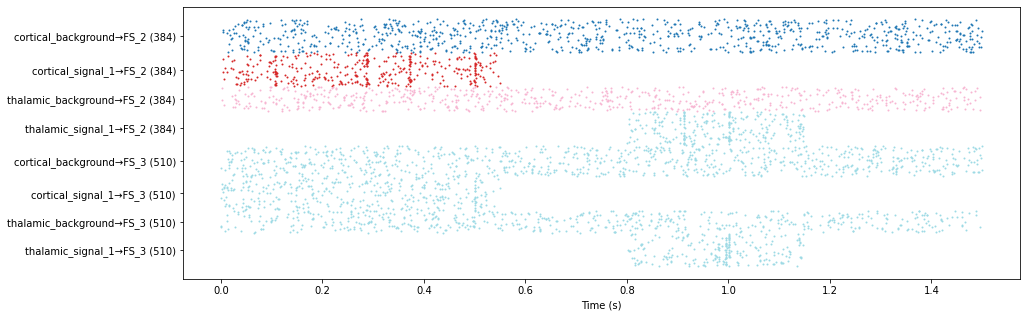

In [11]:
spi.plot_input_population_unit(population_unit_id=1, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS population unit 2 receives elevated input but no change in correlation.

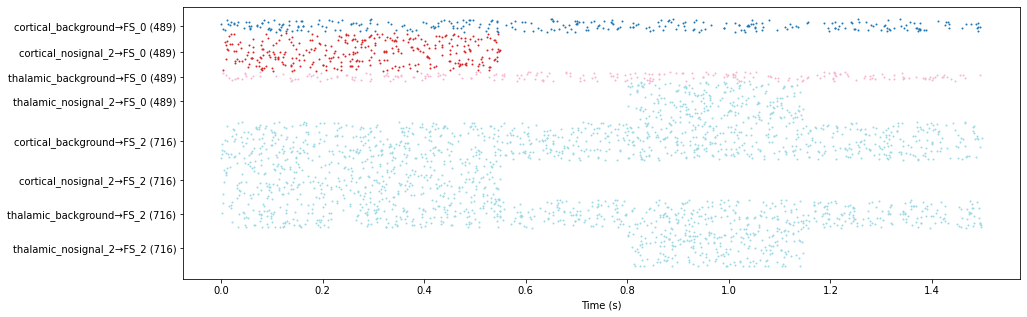

In [12]:
spi.plot_input_population_unit(population_unit_id=2, num_neurons=2, neuron_type="FS", fig_size=(15,5))

FS neurons without population unit receive the same low background input constantly.

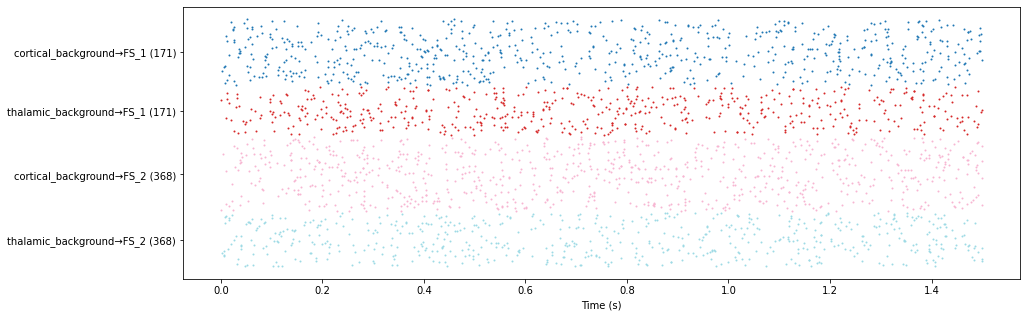

In [13]:
spi.plot_input_population_unit(population_unit_id=0, num_neurons=2, neuron_type="FS", fig_size=(15,5))

### Compile neuron modules

In [14]:
!nrnivmodl ../../../../BasalGangliaData/data/neurons/mechanisms

/home/hjorth/HBP/Snudda/examples/notebooks/FS-network
Mod files: "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/bk_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/ca_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cadyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal12_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal13_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cal_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caldyn_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_fs.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/can_ms.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/cap_ch.mod" "../../../../BasalGangliaData/data/neurons/mechanisms/caq_fs.mod" "../

### Run the simulation

In [ ]:
!mpiexec -n 6 snudda simulate networks/FS_correlation_detection --time 2

numprocs=6
Using input file networks/FS_correlation_detection/input-spikes.hdf5
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
NEURON mechanisms already compiled, make sure you have the correct version of NEURON modules.
If you delete x86_64 directory (or nrnmech.dll) then you will force a recompilation of the modules.
args: Namespace(action='simulate', path='networks/FS_correlation_detection', network_file=None, input_file=None, output_file=None, time=2.0, snudda_data=None, record_volt=True, randomseed=None, neuromodulation=None, disable_synapses=False, disable_gj=False, mech_dir=None, profile=False, verbose=False, exportCoreNeuron=False, record_all=None)
Reading SNUDDA_DATA=None from networks/FS_correlation_detection/network-config.json
Reading SNUDDA_DATA=../../../../BasalGangliaData/data/ from environment variable $SNUDDA_DATA
Using input file networks/

Found 1630 local gap junctions on node.
Found 1743 local gap junctions on node.
Found 1870 local gap junctions on node.
Found 1825 local gap junctions on node.
Found 1789 local gap junctions on node.
Found 1641 local gap junctions on node.
Running simulation for 2000.0 ms.
Running simulation for 2000.0 ms.
Running simulation for 2000.0 ms.
Running simulation for 2000.0 ms.
Running simulation for 2000.0 ms.
Running simulation for 2000.0 ms.
Running simulation for 2.0 s
Running simulation for 2.0 s
Running simulation for 2.0 s
Running simulation for 2.0 s
Running simulation for 2.0 s
Running simulation for 2.0 s
Running Neuron simulator 2000 ms, with dt=0.025
Running Neuron simulator 2000 ms, with dt=0.025
Running Neuron simulator 2000 ms, with dt=0.025
Running Neuron simulator 2000 ms, with dt=0.025
Running Neuron simulator 2000 ms, with dt=0.025
Running Neuron simulator 2000 ms, with dt=0.025
1% done. Elapsed: 66.8 s, estimated time left: 6618.0 s
3% done. Elapsed: 199.7 s, estimated t

In [ ]:
!mpiexec -n 6 snudda simulate networks/FS_correlation_detection --time 2 --disableGJ --outputFile networks/FS_correlation_detection/simulation/output-no-GJ.hdf5

In [ ]:
from snudda.plotting.plot_cross_correlogram import PlotCrossCorrelogram
pcc1 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output.hdf5"))
pcc1.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr.png"))

In [ ]:
pcc2 = PlotCrossCorrelogram(os.path.join(network_path, "simulation", "output-no-GJ.hdf5"))
pcc2.plot_all_pair_cross_correlogram(neuron_id=None, fig_file_name=os.path.join(network_path, "figures", "FS-cross-corr-no-gj.png"))

### Plotting

We want to plot the binned frequency for the different populations as a function of time, to see if there is a difference in output frequency during 0.4-0.55 seconds and 1-1.15 seconds. 

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file = os.path.join(network_path, "simulation", "output.hdf5")
fig_file = os.path.join(network_path, "figures")
spr = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file, figure_path=fig_file)
spr.plot_spike_raster()
spr.plot_spike_histogram()

In [ ]:
from snudda.plotting import SnuddaPlotSpikeRaster2
sim_file_no_gj = os.path.join(network_path, "simulation", "output-no-GJ.hdf5")
fig_file_no_gj = os.path.join(network_path, "figures")
spr2 = SnuddaPlotSpikeRaster2(network_path=network_path, simulation_file=sim_file_no_gj, figure_path=fig_file_no_gj)
spr2.plot_spike_raster()
spr2.plot_spike_histogram()

In [ ]:
from snudda.analyse.analyse_striatum import SnuddaAnalyseStriatum
nas = SnuddaAnalyseStriatum(network_path, volume_type="cube")
nas.plot_connection_probability("FS", "FS",
                                dist_3d=True,
                                exp_max_dist=[250e-6],
                                exp_data=[7 / 12.0],
                                exp_data_detailed=[(7, 12)])

In [ ]:
nas.plot_connection_probability("FS", "FS",
                                dist_3d=True,
                                connection_type="gapjunctions",
                                exp_max_dist=[200e-6, 250e-6, 250e-6],
                                exp_data=[6/78.0, 2 / 6.0, 3 / 7.0],
                                exp_data_detailed=[(6, 78), (2, 6), (3, 7)], )